In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep


In [14]:
# Set up variables

page_template = 'https://www.blocket.se/annonser/hela_sverige/fordon/bilar?cb=16&cbl1=13&cg=1020&page={page}&pl=0'

driver = webdriver.Chrome(ChromeDriverManager().install())





====== WebDriver manager ======
Current google-chrome version is 103.0.5060
Get LATEST chromedriver version for 103.0.5060 google-chrome
Driver [/Users/johan.wikstrom/.wdm/drivers/chromedriver/mac64/103.0.5060.53/chromedriver] found in cache
<ipython-input-14-107f9407ff00>:5: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


# Functions

In [30]:




def get_hrefs(driver, page_template):
    """ This function fetches HREF from each page using a page_template"""
    adds_href = []

    for page_number in range(1,10):
        
        current_page = page_template.format(page=page_number)
        driver.get(current_page)
        
        if driver.current_url.find(f'page={page_number}') == -1:  #If blocket reroutes, exit
            return adds_href

        

        adds = WebDriverWait(driver, 5).until(EC.presence_of_all_elements_located((By.CLASS_NAME, "styled__StyledTitleLink-sc-1kpvi4z-11")))
            
        adds_href.extend([add.get_attribute('href') for add in adds if add.text])  # Non empty 


def get_add_params(driver, add_url):
    """ This functions gets car params from each URL"""
    driver.get(add_url)
    # Expand buttons needs to be pressed
    
    expand_buttons = driver.find_elements(by=By.CLASS_NAME, value="ExpandableContent__StyledShowMoreButton-sc-11a0rym-2")
    
    for button in expand_buttons:
        button.click()

    # Get params
    params = driver.find_elements(by=By.CLASS_NAME, value="ParamsWithIcons__StyledParam-sc-hanfos-1")
    car_params = {}
    for param in params:
            text = param.text
            key = text.split('\n')[0]
            value = text.split('\n')[1]
            car_params[key] = value

    # Add a 1 for each feature it has
    features = driver.find_elements(by=By.CLASS_NAME, value="CarFeaturesList__ListItem-sc-1sasr52-2")
    for feature in features:
        text = feature.text
        car_params[text] = 1

    # Get price 
    price = driver.find_element(by=By.CLASS_NAME, value="Price__StyledPrice-sc-crp2x0-0").text
    car_params["price"] = price
    return car_params


# Scraping

In [20]:
# Get all URLs
adds_href = get_hrefs(driver, page_template)
print(f'Number of adds: {len(adds_href)}')

Number of adds: 196


In [31]:
# Iterate over each add and get car params
car_df = pd.DataFrame()

failed_urls = []
add_number = 1
for add_url in adds_href:
    print(f'scraping add {add_number} of {len(adds_href)}')
    add_number += 1
    for i in range(3):
        try:
            car_params = get_add_params(driver, add_url)
            car_params['url'] = add_url
            car_df = car_df.append(car_params, ignore_index=True)
            print('Successfull extraction')
            break
        except Exception as e:
            print(f'failed on url {add_url}')
            sleep(1)
        failed_urls.append(add_url)



scraping add 1 of 196
Successfull extraction
scraping add 2 of 196
failed on url https://www.blocket.se/annons/goteborg/kia_niro_hybrid_1_6__141hk__advance_plus_2/101756405
Successfull extraction
scraping add 3 of 196
failed on url https://www.blocket.se/annons/stockholm/kia_niro_hybrid_1_6_lci__141hk__pluspaket_2/101756314
failed on url https://www.blocket.se/annons/stockholm/kia_niro_hybrid_1_6_lci__141hk__pluspaket_2/101756314
Successfull extraction
scraping add 4 of 196
Successfull extraction
scraping add 5 of 196
Successfull extraction
scraping add 6 of 196
failed on url https://www.blocket.se/annons/varmland/kia_niro/101754225
failed on url https://www.blocket.se/annons/varmland/kia_niro/101754225
Successfull extraction
scraping add 7 of 196
Successfull extraction
scraping add 8 of 196
failed on url https://www.blocket.se/annons/sodermanland/kia_niro_plug_in_automat_advanceplus2_141hk__dragkrok_v_hjul/101749873
Successfull extraction
scraping add 9 of 196
failed on url https://ww

# Data stuff

In [54]:
car_df.shape

(197, 878)

In [74]:
car_df.dtypes

2 klimatzoner                   float64
ABS-bromsar                     float64
ACC                             float64
Airbag förare                   float64
Airbag passagerare fram         float64
                                 ...   
Takreling i matt krom           float64
Vinterhjul (dubb)               float64
7 Års nybilsgaranti!            float64
Elstol passagerare fram         float64
Uppkopplad genom UVO-Connect    float64
Length: 878, dtype: object

In [51]:
car_df.shape

(188, 837)

In [32]:

car_df.to_csv('niro_20220627.csv', index=False)

In [50]:
car_df = pd.read_csv('niro_20220627.csv')

In [10]:
car_df.price

0      310 300 kr
1      227 900 kr
2      252 000 kr
3      314 900 kr
4      231 500 kr
          ...    
183    322 700 kr
184    376 700 kr
185    356 800 kr
186    356 800 kr
187    356 800 kr
Name: price, Length: 188, dtype: object

In [52]:

number_of_na = car_df.isna().sum()

In [53]:
number_of_na = number_of_na[number_of_na > 100]

In [54]:
car_df = car_df.drop(columns=number_of_na.index)

In [14]:
car_df

,Biltyp,Bränsle,Datum i trafik,Drivning,Färg,Hästkrafter,Miltal,Modell,Modellår,Motorstorlek,Märke,Växellåda,price,url,Multifunktionsratt,Rattvärme,Backkamera,Färddator,Regnsensor,Bluetooth
0,SUV,Miljöbränsle/Hybrid,1970-01-01,Tvåhjulsdriven,Svart (Aurora Black),105 Hk,0,KIA NIRO,2022.0,1580 cc,KIA,Automat,310 300 kr,https://c.eacla.com/clc.php?ai=3184264&bi=4164...,NaN,NaN,NaN,NaN,NaN,NaN
1,SUV,Miljöbränsle/Hybrid,2019-05-28,Tvåhjulsdriven,Vit (Vit Metallic),105 Hk,2 610,KIA NIRO,2019.0,1580 cc,KIA,Automat,227 900 kr,https://www.blocket.se/annons/goteborg/kia_nir...,NaN,NaN,NaN,NaN,NaN,NaN
2,SUV,Bensin,2019-10-09,Tvåhjulsdriven,Vit,105 Hk,975,KIA NIRO,2020.0,1580 cc,KIA,Automat,252 000 kr,https://www.blocket.se/annons/stockholm/kia_ni...,NaN,NaN,NaN,NaN,NaN,NaN
3,SUV,Miljöbränsle/Hybrid,2021-03-22,Tvåhjulsdriven,Grå (Silver),105 Hk,1 500,KIA NIRO,2021.0,1580 cc,KIA,Automat,314 900 kr,https://www.blocket.se/annons/goteborg/kia_nir...,1.0,1.0,NaN,NaN,NaN,NaN
4,SUV,Miljöbränsle/Hybrid,2017-10-31,Tvåhjulsdriven,Vit,105 Hk,3 916,KIA NIRO 1.6 HYBRID DCT6 NIRO,2018.0,1580 cc,KIA,Automat,231 500 kr,https://www.blocket.se/annons/orebro/kia_niro_...,NaN,NaN,1.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,Halvkombi,Bensin,2022-01-10,Tvåhjulsdriven,Vit (/Ud/Clear White),105 Hk,0,KIA NIRO,2022.0,1580 cc,KIA,Automat,322 700 kr,https://www.blocket.se/annons/dalarna/kia_niro...,NaN,NaN,1.0,NaN,1.0,NaN
184,NaN,Bensin,NaN,NaN,NaN,NaN,0,NaN,2021.0,NaN,NaN,Manuell,376 700 kr,https://www.blocket.se/annons/vasterbotten/kia...,NaN,NaN,NaN,NaN,NaN,NaN
185,SUV,Miljöbränsle/Hybrid,2020-08-12,Tvåhjulsdriven,Grå,105 Hk,0,KIA NIRO,2021.0,1580 cc,KIA,Automat,356 800 kr,https://www.blocket.se/annons/uppsala/kia_niro...,NaN,1.0,1.0,NaN,1.0,NaN
186,SUV,Miljöbränsle/Hybrid,2020-07-31,Tvåhjulsdriven,Grå,105 Hk,0,KIA NIRO,2021.0,1580 cc,KIA,Automat,356 800 kr,https://www.blocket.se/annons/uppsala/kia_niro...,NaN,1.0,1.0,NaN,1.0,NaN


In [55]:
car_df = car_df.dropna(subset=['Hästkrafter', 'price', 'Motorstorlek', 'Miltal'])

In [56]:
car_df = car_df.fillna(0)

In [57]:
car_df

,Biltyp,Bränsle,Datum i trafik,Drivning,Färg,Hästkrafter,Miltal,Modell,Modellår,Motorstorlek,Märke,Växellåda,price,url,Multifunktionsratt,Rattvärme,Backkamera,Färddator,Regnsensor,Bluetooth
0,SUV,Miljöbränsle/Hybrid,1970-01-01,Tvåhjulsdriven,Svart (Aurora Black),105 Hk,0,KIA NIRO,2022.0,1580 cc,KIA,Automat,310 300 kr,https://c.eacla.com/clc.php?ai=3184264&bi=4164...,0.0,0.0,0.0,0.0,0.0,0.0
1,SUV,Miljöbränsle/Hybrid,2019-05-28,Tvåhjulsdriven,Vit (Vit Metallic),105 Hk,2 610,KIA NIRO,2019.0,1580 cc,KIA,Automat,227 900 kr,https://www.blocket.se/annons/goteborg/kia_nir...,0.0,0.0,0.0,0.0,0.0,0.0
2,SUV,Bensin,2019-10-09,Tvåhjulsdriven,Vit,105 Hk,975,KIA NIRO,2020.0,1580 cc,KIA,Automat,252 000 kr,https://www.blocket.se/annons/stockholm/kia_ni...,0.0,0.0,0.0,0.0,0.0,0.0
3,SUV,Miljöbränsle/Hybrid,2021-03-22,Tvåhjulsdriven,Grå (Silver),105 Hk,1 500,KIA NIRO,2021.0,1580 cc,KIA,Automat,314 900 kr,https://www.blocket.se/annons/goteborg/kia_nir...,1.0,1.0,0.0,0.0,0.0,0.0
4,SUV,Miljöbränsle/Hybrid,2017-10-31,Tvåhjulsdriven,Vit,105 Hk,3 916,KIA NIRO 1.6 HYBRID DCT6 NIRO,2018.0,1580 cc,KIA,Automat,231 500 kr,https://www.blocket.se/annons/orebro/kia_niro_...,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,SUV,Miljöbränsle/Hybrid,2019-03-22,Tvåhjulsdriven,Grå,105 Hk,3 000,KIA NIRO,2019.0,1580 cc,KIA,Automat,234 900 kr,https://www.blocket.se/annons/alvsborg/kia_nir...,1.0,1.0,1.0,1.0,1.0,1.0
183,Halvkombi,Bensin,2022-01-10,Tvåhjulsdriven,Vit (/Ud/Clear White),105 Hk,0,KIA NIRO,2022.0,1580 cc,KIA,Automat,322 700 kr,https://www.blocket.se/annons/dalarna/kia_niro...,0.0,0.0,1.0,0.0,1.0,0.0
185,SUV,Miljöbränsle/Hybrid,2020-08-12,Tvåhjulsdriven,Grå,105 Hk,0,KIA NIRO,2021.0,1580 cc,KIA,Automat,356 800 kr,https://www.blocket.se/annons/uppsala/kia_niro...,0.0,1.0,1.0,0.0,1.0,0.0
186,SUV,Miljöbränsle/Hybrid,2020-07-31,Tvåhjulsdriven,Grå,105 Hk,0,KIA NIRO,2021.0,1580 cc,KIA,Automat,356 800 kr,https://www.blocket.se/annons/uppsala/kia_niro...,0.0,1.0,1.0,0.0,1.0,0.0


In [58]:
# Cleanup
car_df['Hästkrafter'] = car_df['Hästkrafter'].str.replace(' Hk', '').astype(int)
car_df['price'] = car_df['price'].str.replace(' kr', '').str.replace(' ', '').astype(int)
car_df['Motorstorlek'] = car_df['Motorstorlek'].str.replace(' cc', '').astype(int)
car_df['Miltal'] = car_df['Miltal'].str.replace(' ', '').str.replace(r'\d*-', '').astype(int)


<ipython-input-58-4ee36fcdcc6a>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  car_df['Miltal'] = car_df['Miltal'].str.replace(' ', '').str.replace(r'\d*-', '').astype(int)


<AxesSubplot:>

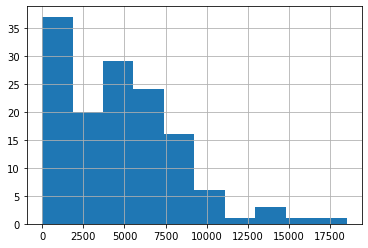

In [59]:
car_df.Miltal.hist()

In [60]:
car_df = car_df.drop(columns=['Datum i trafik', 'Färg', 'Modell', 'Märke'])

In [61]:
car_df.select_dtypes('object').columns.drop('url')

Index(['Biltyp', 'Bränsle', 'Drivning', 'Växellåda'], dtype='object')

In [62]:
car_df = pd.get_dummies(car_df, columns=car_df.select_dtypes('object').columns.drop('url'))

# Modelling

In [63]:
cols_to_keep = ['Hästkrafter', 'Miltal', 'Modellår', 'Motorstorlek']

In [64]:
X = car_df.drop(columns=['price', 'url'])
Y = car_df['price']

In [65]:
Y

0      310300
1      227900
2      252000
3      314900
4      231500
        ...  
182    234900
183    322700
185    356800
186    356800
187    356800
Name: price, Length: 138, dtype: int64

In [66]:
X

,Hästkrafter,Miltal,Modellår,Motorstorlek,Multifunktionsratt,Rattvärme,Backkamera,Färddator,Regnsensor,Bluetooth,Biltyp_Halvkombi,Biltyp_Kombi,Biltyp_SUV,Bränsle_Bensin,Bränsle_Miljöbränsle/Hybrid,Drivning_Tvåhjulsdriven,Växellåda_Automat,Växellåda_Manuell
0,105,0,2022.0,1580,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,1,1,0
1,105,2610,2019.0,1580,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,1,1,0
2,105,975,2020.0,1580,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,0,1,1,0
3,105,1500,2021.0,1580,1.0,1.0,0.0,0.0,0.0,0.0,0,0,1,0,1,1,1,0
4,105,3916,2018.0,1580,0.0,0.0,1.0,1.0,1.0,0.0,0,0,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,105,3000,2019.0,1580,1.0,1.0,1.0,1.0,1.0,1.0,0,0,1,0,1,1,1,0
183,105,0,2022.0,1580,0.0,0.0,1.0,0.0,1.0,0.0,1,0,0,1,0,1,1,0
185,105,0,2021.0,1580,0.0,1.0,1.0,0.0,1.0,0.0,0,0,1,0,1,1,1,0
186,105,0,2021.0,1580,0.0,1.0,1.0,0.0,1.0,0.0,0,0,1,0,1,1,1,0


In [67]:
model = LinearRegression()
model.fit(X,Y)

LinearRegression()

In [72]:
model.coef_

array([ 0.00000000e+00, -4.39792091e+00,  2.27941534e+04,  0.00000000e+00,
       -2.41039786e+03, -1.76698205e+03,  1.06498939e+04, -3.87493257e+03,
        3.81518556e+03,  2.88197342e+03,  6.18452271e+02, -2.26749371e+03,
        1.64904143e+03, -2.56806681e+03,  2.56806681e+03,  0.00000000e+00,
        1.00576193e+04, -1.00576193e+04])

In [73]:
pd.DataFrame({'col': X.columns, 'coef': model.coef_})

,col,coef
0,Hästkrafter,0.000000
1,Miltal,-4.397921
2,Modellår,22794.153439
3,Motorstorlek,0.000000
4,Multifunktionsratt,-2410.397859
5,Rattvärme,-1766.982053
6,Backkamera,10649.893891
7,Färddator,-3874.932566
8,Regnsensor,3815.185557
9,Bluetooth,2881.973424


In [21]:
x = pd.Series(
    {
        'Hästkrafter': 105,
        'Miltal': 5148,
        'Modellår': 2017,
        'Motorstorlek': 1580,
        'Multifunktionsratt': 1,
        'Rattvärme': 1 ,
        'Backkamera': 1,
        'Färddator': 1,
        'Regnsensor': 1,
        'Bluetooth': 1,
        'Biltyp_Halvkombi': 0,
        'Biltyp_Kombi': 0,
        'Biltyp_SUV': 1,
        'Bränsle_Bensin': 0,
        'Bränsle_Miljöbränsle/Hybrid': 1,
        'Drivning_Tvåhjulsdriven': 1,
        'Växellåda_Automat': 1,
        'Växellåda_Manuell': 0,
        
    }
)
model.predict(x.values.reshape(1,-1))

array([214569.64680495])

In [30]:
x = pd.Series(
    {
        'Hästkrafter': 105,
        'Miltal': 4263,
        'Modellår': 2020,
        'Motorstorlek': 1580,
        'Multifunktionsratt': 1,
        'Rattvärme': 1 ,
        'Backkamera': 1,
        'Färddator': 1,
        'Regnsensor': 1,
        'Bluetooth': 1,
        'Biltyp_Halvkombi': 0,
        'Biltyp_Kombi': 0,
        'Biltyp_SUV': 1,
        'Bränsle_Bensin': 0,
        'Bränsle_Miljöbränsle/Hybrid': 1,
        'Drivning_Tvåhjulsdriven': 1,
        'Växellåda_Automat': 1,
        'Växellåda_Manuell': 0,
        
    }
)
model.predict(x.values.reshape(1,-1))

array([286844.26712807])

In [33]:
x = pd.Series(
    {
        'Hästkrafter': 105,
        'Miltal': 1159,
        'Modellår': 2021,
        'Motorstorlek': 1580,
        'Multifunktionsratt': 1,
        'Rattvärme': 1 ,
        'Backkamera': 1,
        'Färddator': 1,
        'Regnsensor': 1,
        'Bluetooth': 1,
        'Biltyp_Halvkombi': 0,
        'Biltyp_Kombi': 0,
        'Biltyp_SUV': 1,
        'Bränsle_Bensin': 0,
        'Bränsle_Miljöbränsle/Hybrid': 1,
        'Drivning_Tvåhjulsdriven': 1,
        'Växellåda_Automat': 1,
        'Växellåda_Manuell': 0,
        
    }
)
model.predict(x.values.reshape(1,-1))

array([323289.56707039])

In [28]:
x.values.reshape(1,-1)

array([[ 105, 8250, 2018, 1580,    1,    1,    1,    1,    1,    1,    0,
           0,    1,    0,    1,    1,    1,    0]])

In [74]:
pred_price = model.predict(X)

In [29]:
min(Y - pred_price)

-53058.68442761898

In [75]:
car_df['pred_price'] = pred_price

In [76]:
car_df['price_diff'] = car_df['price'] - car_df['pred_price']

In [84]:
car_df[(car_df.Modellår == 2022) & (car_df.Miltal ==0)]

,Hästkrafter,Miltal,Modellår,Motorstorlek,price,url,Multifunktionsratt,Rattvärme,Backkamera,Färddator,...,Biltyp_Halvkombi,Biltyp_Kombi,Biltyp_SUV,Bränsle_Bensin,Bränsle_Miljöbränsle/Hybrid,Drivning_Tvåhjulsdriven,Växellåda_Automat,Växellåda_Manuell,pred_price,price_diff
0,105,0,2022.0,1580,310300,https://c.eacla.com/clc.php?ai=3184264&bi=4164...,0.0,0.0,0.0,0.0,...,0,0,1,0,1,1,1,0,341886.170449,-31586.170449
8,105,0,2022.0,1580,295300,https://www.blocket.se/annons/vastmanland/kia_...,1.0,1.0,1.0,0.0,...,0,0,1,0,1,1,1,0,348358.684428,-53058.684428
57,105,0,2022.0,1580,310300,https://www.blocket.se/annons/sodermanland/kia...,0.0,0.0,0.0,0.0,...,0,0,1,0,1,1,1,0,341886.170449,-31586.170449
77,105,0,2022.0,1580,307700,https://www.blocket.se/annons/blekinge/kia_nir...,1.0,1.0,0.0,0.0,...,0,0,1,0,1,1,1,0,337708.790537,-30008.790537
79,105,0,2022.0,1580,314200,https://www.blocket.se/annons/blekinge/kia_nir...,1.0,1.0,0.0,0.0,...,0,0,1,0,1,1,1,0,337708.790537,-23508.790537
87,105,0,2022.0,1580,309300,https://www.blocket.se/annons/dalarna/kia_niro...,0.0,0.0,0.0,0.0,...,1,0,0,0,1,1,1,0,340855.581285,-31555.581285
88,105,0,2022.0,1580,309300,https://www.blocket.se/annons/dalarna/kia_niro...,0.0,0.0,0.0,0.0,...,1,0,0,0,1,1,1,0,340855.581285,-31555.581285
181,105,0,2022.0,1580,314200,https://www.blocket.se/annons/blekinge/kia_nir...,1.0,1.0,0.0,0.0,...,0,0,1,0,1,1,1,0,337708.790537,-23508.790537
183,105,0,2022.0,1580,322700,https://www.blocket.se/annons/dalarna/kia_niro...,0.0,0.0,1.0,0.0,...,1,0,0,1,0,1,1,0,350184.527115,-27484.527115


In [85]:
import seaborn as sns


<AxesSubplot:xlabel='Modellår', ylabel='price_diff'>

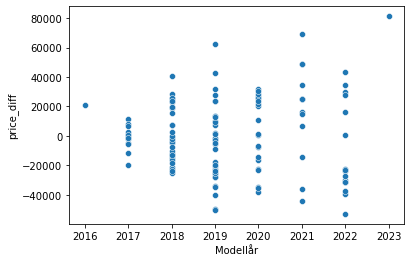

In [94]:
sns.scatterplot(data=car_df, x="Modellår", y="price_diff")

In [52]:
print(car_df[car_df.price < 210000].sort_values(by='price_diff')[['url', 'price_diff']])

                                                                                                                                                                                                         url  \
103                                                                                               https://www.blocket.se/annons/stockholm/kia_niro_hybrid_dct_ex_gls_141hk_b_kamera___navi___lader/101349674   
70                                                                                                            https://www.blocket.se/annons/goteborg/kia_niro_hybrid_dct_141hk_advance_pluspaket_2/101562225   
165                                                                                                   https://www.blocket.se/annons/orebro/kia_niro_hybrid_1_6_gdi_dct_141hk__motor___kup_varmare_/100880914   
135                                                                                            https://www.blocket.se/annons/blekinge/kia_niro_hybrid_1_6_gdi_aut_ex_gls

In [1]:
car_df[car_df.price < 210000].sort_values(by='price_diff').iloc[7]

NameError: name 'car_df' is not defined